# Guéant–Lehalle–Fernandez-Tapia Market Making Model and Grid Trading

## Overview

Grid trading is straightforward and easy to comprehend, and it excels in high-frequency environments. However, given the intricacies of high-frequency trading, which necessitate comprehensive tick-by-tick simulation with latencies and order fill simulation, optimizing the ideal spread, order interval, and skew can be a challenging task. Furthermore, these values fluctuate over time, especially in response to market conditions, making a fixed setup less than optimal.

To improve grid trading's adaptability, one solution is to combine it with a well-developed market-making model. Let's delve into how this can be achieved.

## Guéant–Lehalle–Fernandez-Tapia Market Making Model

This model represents an advanced evolution of the well-known Avellaneda-Stoikov model and provides a closed-form approximation of asymptotic behavior for terminal time T. Simply, this model does not specify a terminal time, which makes it suitable for typical stocks, spot assets, or crypto perpetual contracts. By employing this model, it is anticipated that the half spread and skew will be accurately adjusted according to market conditions.

In this analysis, we will focus on equations (4.6) and (4.7) in [Optimal market making](https://arxiv.org/abs/1605.01862) and explore how they can be applied to real-world scenarios.

The optimal bid quote depth, $\delta^{b*}_{approx}$, and ask quote depth, $\delta^{a*}_{approx}$, are derived from the fair price as follows:

\begin{align}
\delta^{b*}_{approx}(q) = {1 \over {\xi \Delta}}log(1 + {\xi \Delta \over k}) + {{2q + \Delta} \over 2}\sqrt{{{\gamma \sigma^2} \over {2A\Delta k}}(1 + {\xi \Delta \over k})^{{k \over {\xi \Delta}} + 1}} \label{eq4.6}\tag{4.6} \\
\delta^{a*}_{approx}(q) = {1 \over {\xi \Delta}}log(1 + {\xi \Delta \over k}) - {{2q - \Delta} \over 2}\sqrt{{{\gamma \sigma^2} \over {2A\Delta k}}(1 + {\xi \Delta \over k})^{{k \over {\xi \Delta}} + 1}} \label{eq4.7}\tag{4.7}
\end{align}

Let's introduce $c_1$ and $c_2$ and define them by extracting the volatility 𝜎 from the square root:

\begin{align}
c_1 = {1 \over {\xi \Delta}}log(1 + {\xi \Delta \over k}) \\
c_2 = \sqrt{{\gamma \over {2A\Delta k}}(1 + {\xi \Delta \over k})^{{k \over {\xi \Delta}} + 1}}
\end{align}

Now we can rewrite equations (4.6) and (4.7) as follows:

\begin{align}
\delta^{b*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 + q \sigma c_2 \\
\delta^{a*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 - q \sigma c_2
\end{align}

As you can see, this consists of the half spread and skew. $q$ represents a market maker's inventory(position).

\begin{align}
\text{half spread} = C_1 + {\Delta \over 2} \sigma C_2 \\
\text{skew} = \sigma C_2 \\
\delta^{b*}_{approx}(q) = \text{half spread} + \text{skew} \times q \\
\delta^{a*}_{approx}(q) = \text{half spread} - \text{skew} \times q
\end{align}

Thus,

\begin{align}
\text{bid price} = \text{fair price} - (\text{half spread} + \text{skew} \times q) \\
\text{ask price} = \text{fair price} + (\text{half spread} - \text{skew} \times q)
\end{align}

You can find similarities in what the following two articles describe.  
[Stochastic Control Theory and High Frequency Trading](https://ieor.columbia.edu/files/seasdepts/industrial-engineering-operations-research/pdf-files/Borden_D_FESeminar_Sp10.pdf)  
[How to Market Make Bitcoin Derivatives Lesson 2](https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-2/)  

## Calculating Trading Intensity

To determine the optimal quotes, we need to compute $c_1$ and $c_2$. In order to do that, we need to calibrate $A$ and $k$ of trading intensity, as well as calculate the market volatility $\sigma$.

Trading intensity is defined as:

$$ \lambda = A \exp (-k \delta) $$

We will calibrate these values using market data according to [the this article](https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem). In order to do that, we need to record market order's arrivals.

Our market maker will react every 100ms, which means they will post or cancel orders at this interval. So, our quotes' trading intensity will be measured in the same time-step. Ideally, we should also account for our orders' queue position; however, to simplify the problem, we will not consider the order queue position in this analysis.

In [1]:
from numba import njit
from hftbacktest import BUY, SELL

import numpy as np

@njit
def measure_trading_intensity_and_volatility(hbt):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
    return arrival_depth[:t], mid_price_chg[:t]

Since we're not considering the order's queue position when measuring trading intensity, only market trades that cross our quote will be counted as executed.

In [2]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

Run HftBacktest to replay the market and record order arrival depth and price changes.

In [3]:
from hftbacktest import HftBacktest, FeedLatency, Linear

hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
    ],
    snapshot='data/ethusdt_20221002_eod.npz',
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    asset_type=Linear,
    order_latency=FeedLatency(),
    trade_list_size=10_000,
)

arrival_depth, mid_price_chg = measure_trading_intensity_and_volatility(hbt)

Load data/ethusdt_20221003.npz


Measure trading intensity from the recorded order arrival depth and plot it.

In [4]:
tmp = np.zeros(500, np.float64) 

# Measures trading intensity (lambda) for the first 10-minute window.
lambda_ = measure_trading_intensity(arrival_depth[:6_000], tmp)

# Since it is measured for a 10-minute window, divide by 600 to convert it to per second.
lambda_ /= 600

# Creates ticks from the mid-price.
ticks = np.arange(len(lambda_)) + .5

Text(0, 0.5, 'Count (per second)')

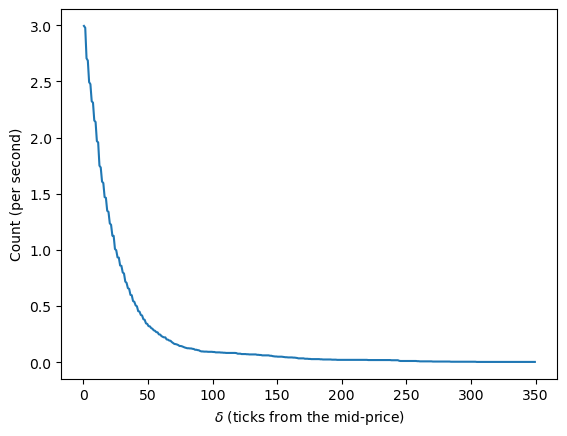

In [5]:
from matplotlib import pyplot as plt

plt.plot(ticks, lambda_)
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')

Calibrate $A$ and $k$ using linear regression, since by taking the logarithm of both sides of lambda, it becomes $log \lambda = -k \delta + logA$.

In [6]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

In [7]:
y = np.log(lambda_)
k_, logA = linear_regression(ticks, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=0.8793116000410844, k=0.01761086117922129


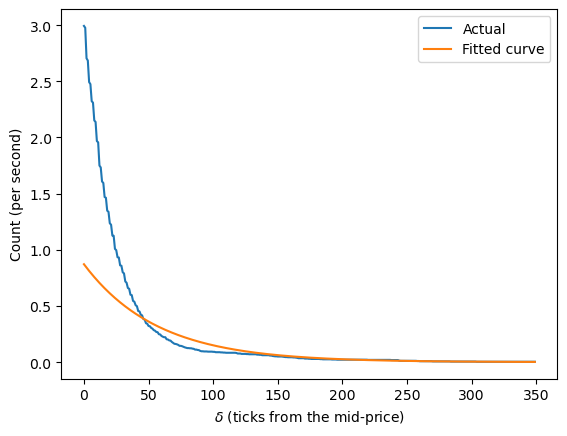

In [8]:
plt.plot(lambda_)
plt.plot(A * np.exp(-k * ticks))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

As you can see, the fitted lambda function is not accurate across the entire range. More specifically, it overestimates the trading intensity for the shallow range near the mid-price and underestimates it for the deep range away from the mid-price.

Since our quotes are likely to be placed in the range close to the mid-price, at least under typical market conditions (excluding high volatility conditions), we will refit the function specifically for the nearest range.

In [9]:
# Refits for the range un to 70 ticks.
x_shallow = ticks[:70]
lambda_shallow = lambda_[:70]

y = np.log(lambda_shallow)
k_, logA = linear_regression(x_shallow, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=2.9932203436865956, k=0.04249732177397641


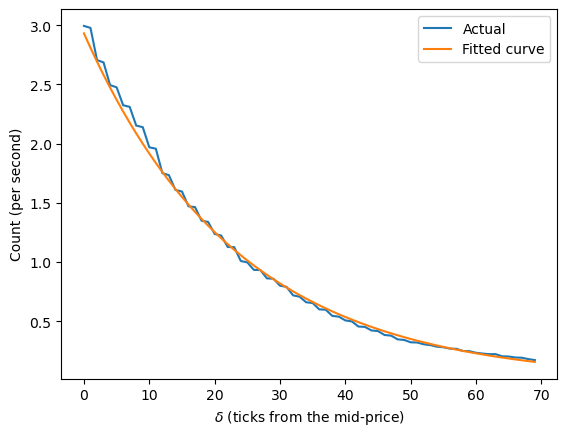

In [10]:
plt.plot(lambda_shallow)
plt.plot(A * np.exp(-k * x_shallow))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

Now, we have a more accurate trading intensity function. Let's see where our quote will be placed.

But before we do that, let's calculate the volatility first.

In [11]:
# Since we need volatility in ticks per square root of a second and our measurement is every 100ms, 
# multiply by the square root of 10.
volatility = np.nanstd(mid_price_chg) * np.sqrt(10)
print(volatility)

10.690046868333601


Compute $c_1$ and $c_2$ according to the equations.

In [12]:
@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

In the Guéant–Lehalle–Fernandez-Tapia formula, $\Delta = 1$ and $\xi = \gamma$. the value of $\gamma$ is arbitrarily chosen.

In [13]:
gamma = 0.05
delta = 1
volatility = 10.69

c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

half_spread = 1 * c1 + 1 / 2 * c2 * volatility
skew = c2 * volatility
print('half_spread={}, skew={}'.format(half_spread, skew))

half_spread=20.419892817641397, skew=9.7302402975805


What does it mean when your quote is positioned 20 ticks away from the mid-price? By analyzing the recorded order arrival depth, you can identify the number of market trades you'll participate in as a market maker, measured in terms of count instead of volume. Additionally, the skew appears to be quite strong, as accumulating just two positions offsets the entire half spread.

In [14]:
from scipy import stats

# inverse of percentile
pct = stats.percentileofscore(arrival_depth[np.isfinite(arrival_depth)], half_spread)
your_pct = 100 - pct
print('{:.2f}%'.format(your_pct))

1.86%


Approximately 1.86% of market trades per given time-step could execute your quote. Be aware that it's not the percentage of the traded quantity.

## Implement a Market Maker using the Model


<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In this example, we will disregard the forecast term and assume that the fair price is equal to the mid price, as we can expect the intrinsic value to remain stable in the short term.

In [15]:
from numba.typed import Dict

@njit
def glft_market_maker(hbt, stat):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.full((10_000_000, 5), np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1

    order_qty = 1
    max_position = 20
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position

        bid_price = min(np.round(mid_price_tick - bid_depth), hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(np.round(mid_price_tick + ask_depth), hbt.best_ask_tick) * hbt.tick_size
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Cancel orders if they differ from the updated bid and ask prices.
        for order in hbt.orders.values():
            if order.side == BUY and order.cancellable and order.price != bid_price:
                hbt.cancel(order.order_id)
            if order.side == SELL and order.cancellable and order.price != ask_price:
                hbt.cancel(order.order_id)

        # If the current position is within the maximum position,
        # submit the new order only if no order exists at the same price.
        if hbt.position < max_position and np.isfinite(bid_price):
            bid_price_as_order_id = round(bid_price / hbt.tick_size)
            if bid_price_as_order_id not in hbt.orders:
                hbt.submit_buy_order(bid_price_as_order_id, bid_price, order_qty, GTX)
        if hbt.position > -max_position and np.isfinite(ask_price):
            ask_price_as_order_id = round(ask_price / hbt.tick_size)
            if ask_price_as_order_id not in hbt.orders:
                hbt.submit_sell_order(ask_price_as_order_id, ask_price, order_qty, GTX)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        out[t, 0] = half_spread
        out[t, 1] = skew
        out[t, 2] = volatility
        out[t, 3] = A
        out[t, 4] = k
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return out[:t]

Load data/ethusdt_20221003.npz
=========== Summary ===========
Sharpe ratio: -271.1
Sortino ratio: -306.4
Risk return ratio: -365.0
Annualised return: -2213.36 %
Max. draw down: 6.06 %
The number of trades per day: 6828
Avg. daily trading volume: 6828
Avg. daily trading amount: 8859717
Max leverage: 1.45
Median leverage: 0.00


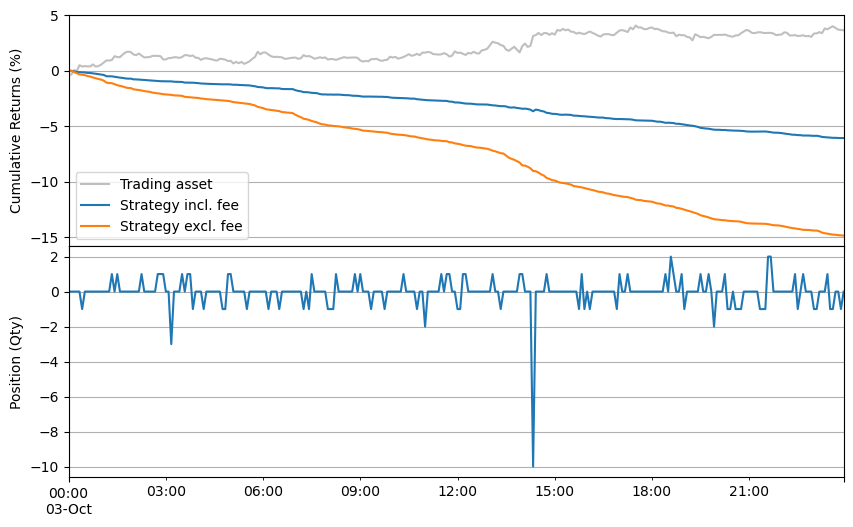

In [16]:
from hftbacktest import SquareProbQueueModel, Stat, GTX

hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

out = glft_market_maker(hbt, stat.recorder)

stat.summary(capital=10_000)

## Adjustment factors

It looks like the skew is too strong, which is why the market maker is hesitant to take on the position. To alleviate the skew, you can introduce adjustment factors, $adj_1$ and $adj_2$, to the calculated half spread and skew, as follow.

$$
\text{half spread}_{adj} = \text{half spread} \times adj_1 \\
\text{skew}_{adj} = \text{skew} \times adj_2
$$

In [17]:
from numba.typed import Dict

@njit
def glft_market_maker(hbt, stat):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.full((10_000_000, 5), np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05 # Uses the same value as gamma.

    order_qty = 1
    max_position = 20
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position

        bid_price = min(np.round(mid_price_tick - bid_depth), hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(np.round(mid_price_tick + ask_depth), hbt.best_ask_tick) * hbt.tick_size
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Cancel orders if they differ from the updated bid and ask prices.
        for order in hbt.orders.values():
            if order.side == BUY and order.cancellable and order.price != bid_price:
                hbt.cancel(order.order_id)
            if order.side == SELL and order.cancellable and order.price != ask_price:
                hbt.cancel(order.order_id)

        # If the current position is within the maximum position,
        # submit the new order only if no order exists at the same price.
        if hbt.position < max_position and np.isfinite(bid_price):
            bid_price_as_order_id = round(bid_price / hbt.tick_size)
            if bid_price_as_order_id not in hbt.orders:
                hbt.submit_buy_order(bid_price_as_order_id, bid_price, order_qty, GTX)
        if hbt.position > -max_position and np.isfinite(ask_price):
            ask_price_as_order_id = round(ask_price / hbt.tick_size)
            if ask_price_as_order_id not in hbt.orders:
                hbt.submit_sell_order(ask_price_as_order_id, ask_price, order_qty, GTX)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        out[t, 0] = half_spread
        out[t, 1] = skew
        out[t, 2] = volatility
        out[t, 3] = A
        out[t, 4] = k
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return out[:t]

Load data/ethusdt_20221003.npz
=========== Summary ===========
Sharpe ratio: 5.9
Sortino ratio: 5.6
Risk return ratio: 144.6
Annualised return: 172.58 %
Max. draw down: 1.19 %
The number of trades per day: 5497
Avg. daily trading volume: 5497
Avg. daily trading amount: 7131834
Max leverage: 3.42
Median leverage: 0.26


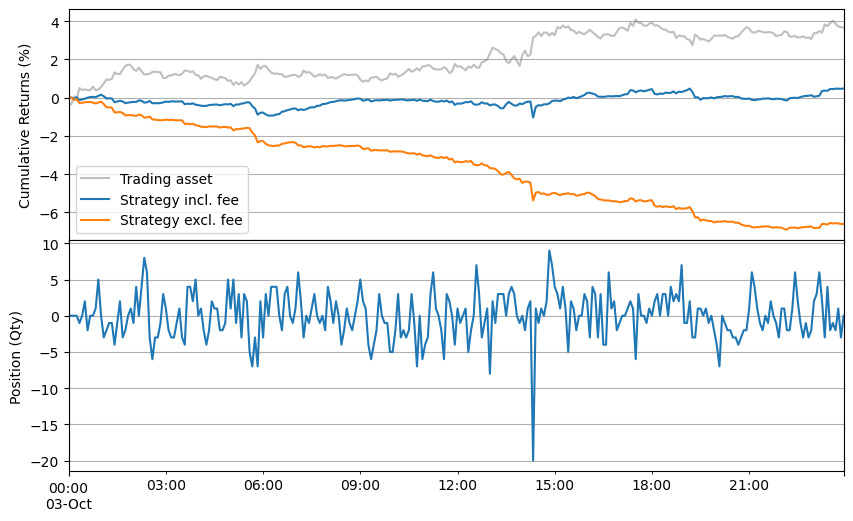

In [18]:
from hftbacktest import SquareProbQueueModel, Stat, GTX

hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

out = glft_market_maker(hbt, stat.recorder)

stat.summary(capital=10_000)

Improved, but even when accounting for rebates, it can only achieve breakeven at best. As shown below, both the half spread and skew move together, primarily influenced by the $c_2$ and the market volatility.

Text(0, 0.5, 'Skew (tick)')

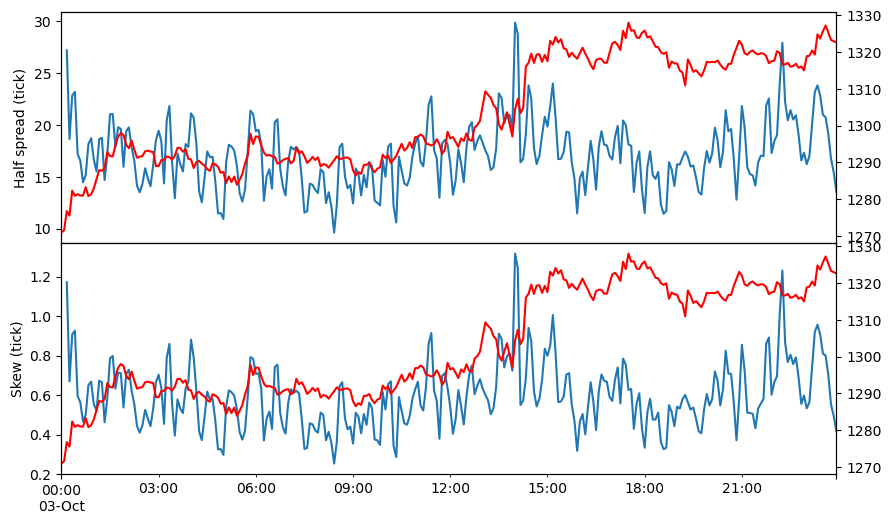

In [19]:
import pandas as pd

dt = stat.datetime()

mid = pd.Series(stat.mid, index=dt)
half_spread = pd.Series(out[:, 0], index=dt)
skew = pd.Series(out[:, 1], index=dt)
volatility = pd.Series(out[:, 2], index=dt)
A = pd.Series(out[:, 3], index=dt)
k = pd.Series(out[:, 4], index=dt)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 6)

half_spread.resample('5min').last().plot(ax=axs[0])
mid.resample('5min').last().plot(ax=axs[0].twinx(), style='r')
axs[0].set_ylabel('Half spread (tick)')

skew.resample('5min').last().plot(ax=axs[1])
mid.resample('5min').last().plot(ax=axs[1].twinx(), style='r')
axs[1].set_ylabel('Skew (tick)')

Text(0, 0.5, 'k ($ tick^{-1} $)')

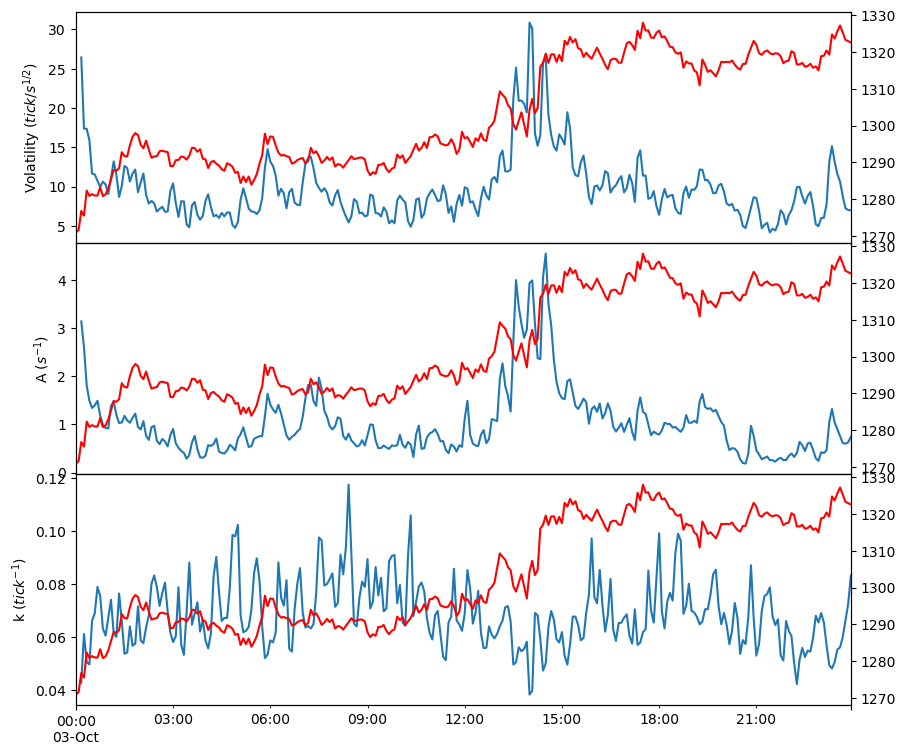

In [20]:
fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 9)

volatility.resample('5min').last().plot(ax=axs[0])
mid.resample('5min').last().plot(ax=axs[0].twinx(), style='r')
axs[0].set_ylabel('Volatility ($ tick/s^{1/2} $)')

A.resample('5min').last().plot(ax=axs[1])
mid.resample('5min').last().plot(ax=axs[1].twinx(), style='r')
axs[1].set_ylabel('A ($ s^{-1} $)')

k.resample('5min').last().plot(ax=axs[2])
mid.resample('5min').last().plot(ax=axs[2].twinx(), style='r')
axs[2].set_ylabel('k ($ tick^{-1} $)')

In the 5-day backtest, it's evident that profits are generated through rebates, as a result of maintaining high trading volume by consistently posting quotes.

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
=========== Summary ===========
Sharpe ratio: 17.3
Sortino ratio: 14.0
Risk return ratio: 282.9
Annualised return: 512.09 %
Max. draw down: 1.81 %
The number of trades per day: 8385
Avg. daily trading volume: 8385
Avg. daily trading amount: 11231937
Max leverage: 5.24
Median leverage: 0.27


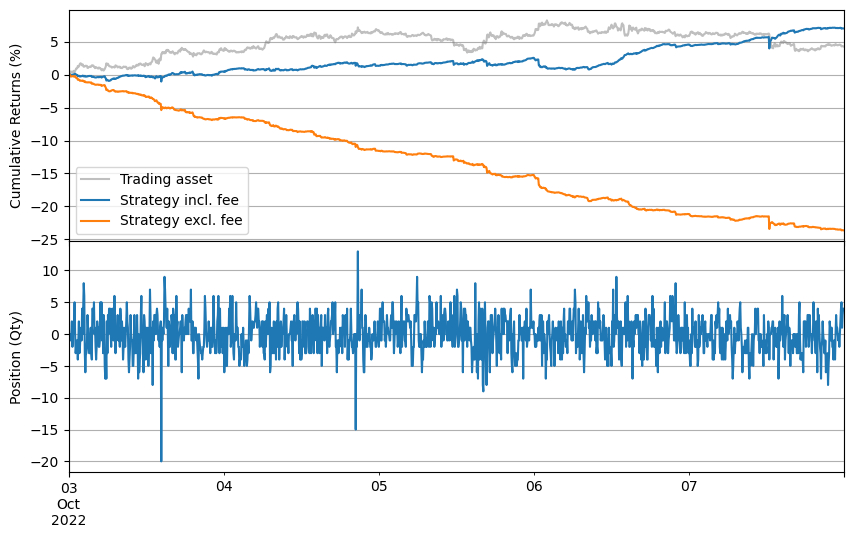

In [21]:
hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

out = glft_market_maker(hbt, stat.recorder)

stat.summary(capital=10_000)

## Integrating Grid Trading

Creating a grid from the bid and ask prices derived from the Guéant–Lehalle–Fernandez-Tapia market making model.

In [22]:
from numba.typed import Dict

@njit
def gridtrading_glft_mm(hbt, stat):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.full((10_000_000, 5), np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05

    order_qty = 1
    max_position = 20
    grid_num = 20
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position
    
        bid_price = min(mid_price_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(mid_price_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        grid_interval = max(np.round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        out[t, 0] = half_spread
        out[t, 1] = skew
        out[t, 2] = volatility
        out[t, 3] = A
        out[t, 4] = k
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return out[:t]

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
=========== Summary ===========
Sharpe ratio: 21.1
Sortino ratio: 20.3
Risk return ratio: 381.1
Annualised return: 395.88 %
Max. draw down: 1.04 %
The number of trades per day: 4547
Avg. daily trading volume: 4547
Avg. daily trading amount: 6092144
Max leverage: 2.09
Median leverage: 0.16


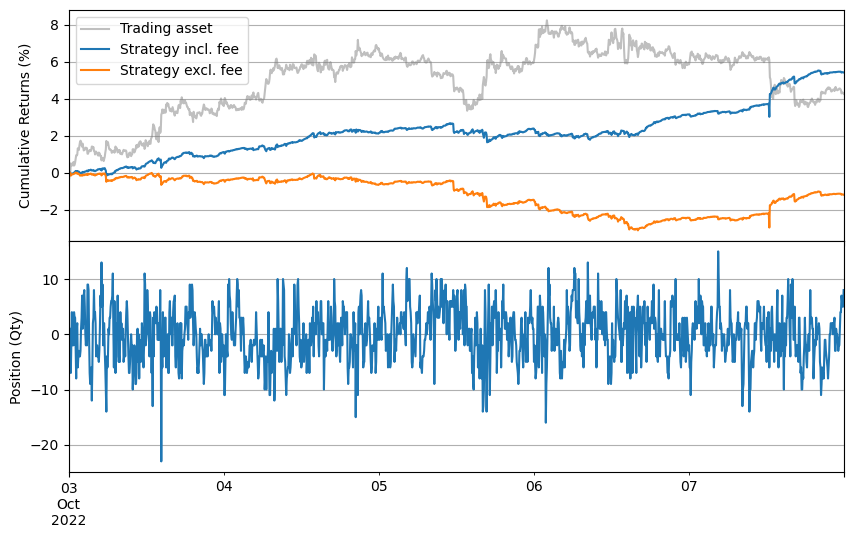

In [23]:
hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

out = gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=25_000)

You can see it works even better with other coins as well. In the next example, we will show how to create multiple markets to achieve better risk-adjusted returns.

=========== Summary ===========
Sharpe ratio: 17.8
Sortino ratio: 16.4
Risk return ratio: 207.0
Annualised return: 768.72 %
Max. draw down: 3.71 %
The number of trades per day: 1912
Avg. daily trading volume: 1912
Avg. daily trading amount: 206843
Max leverage: 1.36
Median leverage: 0.22


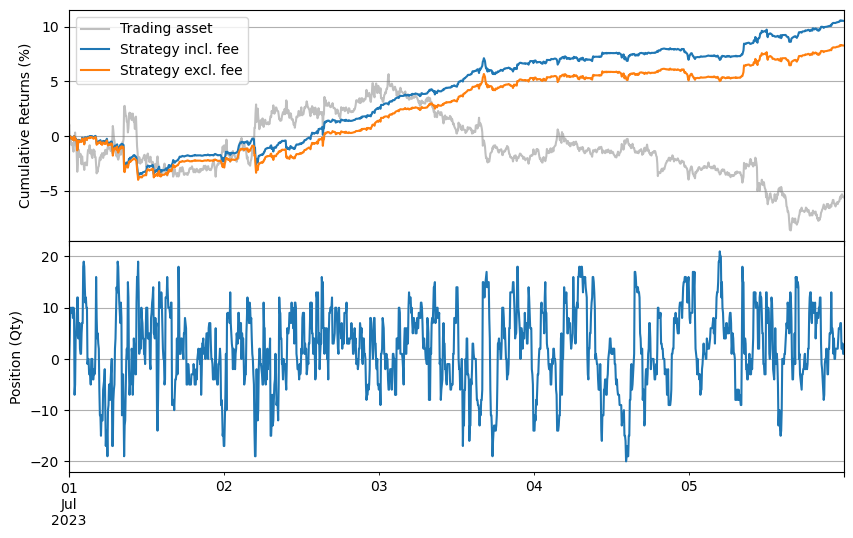

In [23]:
hbt = HftBacktest(
    [
        'data/ltcusdt_20230701.npz',
        'data/ltcusdt_20230702.npz',
        'data/ltcusdt_20230703.npz',
        'data/ltcusdt_20230704.npz',
        'data/ltcusdt_20230705.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='data/ltcusdt_20230630_eod.npz'
)

stat = Stat(hbt)

out = gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=2_500)

## Wrapping up

Thus far, we have illustrated how to apply the model to a real-world example.

For a more effective market-making algorithm, consider dividing this model into the following categories:

* Half-spread: As shown, the half-spread is a function of trading intensity and market volatility. An exponential function used for trading intensity might not be suitable for the entire range. You could develop a more refined approach to convert trading intensity to half-spread. Additionally, while historical trading intensity and market volatility are utilized here, you could forecast short-term trading intensity and volatility to respond more agilely to changes in market conditions. This might involve strategies that use news, events, liquidity vacuums, and other factors to predict volatility explosions.


* Skew: The skew is also a function of trading intensity and market volatility. In this model, only inventory risk is considered, but you can also account for other risks, particularly when making multiple markets. BARRA is a good example of other risks that can be managed similarly.


* Fair Value Pricing: In this model, the fair price is equal to the mid-price, however, you need to incorporate forecasts such as the micro-price and fair value pricing through correlated assets to enhance the strategy.


* Hedging: Hedging is especially crucial when making multiple markets, as it serves as a valuable tool for managing risks.

We will address a few more topics in upcoming examples.

## References
[Dealing with the Inventory Risk - A solution to the market making problem](https://arxiv.org/abs/1105.3115)  
[Optimal market making](https://arxiv.org/abs/1605.01862)  

Knight Capital Group  
[Stochastic Control Theory and High Frequency Trading](https://ieor.columbia.edu/files/seasdepts/industrial-engineering-operations-research/pdf-files/Borden_D_FESeminar_Sp10.pdf)  

BitMEX Market Making Series  
[Algo Trading & Market Making](https://blog.bitmex.com/wp-content/uploads/2019/11/Algo-Trading-and-Market-Making.pdf)  
[How to Market Make Bitcoin Derivatives Lesson 1](https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-1/)  
[How to Market Make Bitcoin Derivatives Lesson 2](https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-2/)  